#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H=13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
E = 210e9

In [20]:
E*Ar

16991625880.187403

In [21]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [22]:
DT=np.diag(diag_DT) # (35) in [2]

In [23]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [24]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [25]:
CT=np.diag(diag_CT)

In [26]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [27]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [28]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [29]:
rng = np.random.default_rng()

In [30]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [32]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.92168219, -0.37760223,  0.08898596],
       [ 0.37077791,  0.92488862,  0.08428981],
       [-0.11413012, -0.04469439,  0.99245994]])

In [33]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.006244


In [34]:
Ret.shape

(50, 3, 3)

In [35]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [36]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float32))) 
    return ans.T

In [37]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000359


In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-4.68231555e+02,  3.92142111e+03, -1.43577266e+04],
       [-2.79458364e+03,  2.02358393e+03, -3.99860271e+03],
       [ 2.50152467e+03, -3.61137530e+03, -7.36758537e+02],
       [ 8.09637309e+03,  2.99982820e+04, -1.77012310e+04],
       [ 1.54841757e+03,  5.22714073e+03, -3.41980206e+03],
       [-5.85765120e+03,  1.87046158e+03, -5.03029238e+03],
       [-6.79719391e+02, -8.60592857e+03, -1.09017130e+04],
       [-4.45437259e+02, -3.42563505e+02, -2.87909035e+02],
       [ 1.59830910e+03, -7.16874890e+03,  3.27016767e+03],
       [ 1.54417631e+04, -6.61957759e+02, -8.65466355e+02],
       [-3.04979153e+03, -5.95934405e+03, -1.69301904e+03],
       [ 1.82247865e+03,  3.52063358e+03,  3.66655956e+03],
       [ 4.12006664e+04, -1.82808213e+00,  5.59512592e-01],
       [-4.34336927e+03,  2.01681263e+02,  5.24764733e+02],
       [-1.02679617e+02,  1.31478155e+04,  4.26842979e+02],
       [ 4.81703718e+03, -5.97544415e+02, -1.01255359e+03],
       [ 2.57972959e+03,  6.25091278e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000338


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000475


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000197


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float32),B.T.astype(np.float32))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 9.80721593e-01, -2.25260854e-03, -8.51899326e-01],
       [-7.84670234e-01,  5.93265831e-01, -7.15203464e-01],
       [ 6.04028046e-01,  1.92776167e+00, -3.28243412e-02],
       [-1.77446067e-01, -9.45121825e-01,  5.47287583e-01],
       [-3.05108100e-01,  8.72852921e-01, -8.08112860e-01],
       [ 3.68684471e-01,  6.92176640e-01, -1.01185369e+00],
       [-1.01481281e-01, -3.11420751e+00, -7.55109549e-01],
       [-3.63874547e-02, -9.27095890e-01, -1.58730745e+00],
       [-4.51842546e-01,  3.06420207e-01,  7.24184871e-01],
       [ 1.10813454e-01, -4.69511509e-01, -2.09061578e-01],
       [-1.86230505e+00, -1.22331333e+00,  1.61865309e-01],
       [-8.31099525e-02, -1.50629357e-01,  1.22571126e-01],
       [ 7.09197104e-01,  3.03750455e-01,  5.32965302e-01],
       [ 1.25349534e+00,  1.72324836e+00, -6.28560543e-01],
       [ 5.50760567e-01,  8.92226756e-01, -1.05692275e-01],
       [ 2.70244747e-01, -3.15866470e-01, -4.49825078e-01],
       [ 6.38984323e-01, -2.14028880e-01

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000243


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.003012


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.002856


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.04991443,  0.12200878,  0.39343788],
       [ 0.93821172, -0.43390148,  0.35263809],
       [-0.17597645, -1.37317774, -1.27824804],
       [-1.59306641, -0.81147234, -1.85713611],
       [ 0.03116258, -1.38099527, -0.60057649],
       [-0.99886566, -0.39270715, -0.66779365],
       [-1.24036678, -3.20245778,  0.52347986],
       [ 0.97063193, -0.16988245,  0.61575632],
       [-2.10725615,  0.34730774, -0.16035994],
       [ 0.28427742, -0.71653369, -1.46469326],
       [ 1.22435087, -0.20742395, -0.31345644],
       [ 0.15530021,  0.61294119, -1.31402107],
       [-0.7798063 , -0.22115808, -0.40526251],
       [-0.09211311, -1.51595708,  0.78556202],
       [-1.02965737, -0.07942998, -0.47037043],
       [-0.71306863,  2.60765628, -0.33739297],
       [ 0.06762542, -1.51695509, -0.97278533],
       [-0.66065619, -1.95339469,  0.95318406],
       [ 0.55510977,  1.05519098, -0.79458693],
       [-0.39531421,  0.97113332, -1.27707002],
       [-0.55375972,  1.21093793,  0.918

In [63]:
def d_s(f,a,b,c,Ret,omega,force): # here
    
    fun = f(a,b,c,Ret,omega, force) 
#     print(fun)
    if any(force):
#         fun[-1]=-np.array(force)
        fun[-1]=-np.dot(Ret[-1],force)
#         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     print(fun)
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float32)).T

In [64]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3])

array([[-8.49638199e-06, -1.30845618e-05, -1.96056636e-05,
         1.49239445e-05, -1.68094893e-05, -1.70401325e-05,
         2.35907431e-05, -6.60204944e-06,  4.17760476e-06,
         2.60447320e-06,  1.38516475e-05,  2.73197743e-06,
         2.29212549e-06, -2.35178533e-05, -9.97909026e-06,
        -1.33957265e-06,  1.62718636e-05, -2.16081083e-06,
         9.28698498e-06,  1.34870049e-06, -7.40138502e-06,
        -1.69855247e-05,  4.93415297e-06, -2.77611009e-06,
         3.64689375e-06,  5.05435167e-07, -5.34122119e-06,
        -2.15820491e-05,  4.98122765e-06,  6.21548490e-06,
         1.50684225e-05,  3.64091114e-06,  2.08240484e-05,
        -4.03074551e-05, -1.80759984e-05,  1.80407587e-05,
         6.32899138e-06, -9.76910335e-08,  1.98567578e-05,
        -5.39101143e-06, -4.75138580e-06, -9.22541793e-06,
         8.61882033e-06,  1.21049603e-05,  3.96277985e-06,
         8.40008629e-07,  2.94119926e-06, -7.21634425e-06,
         3.24754952e-05,  1.48865328e-05],
       [ 1.83

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.001721


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[-1.85216390e-06,  2.11742316e-07, -2.19144387e-06,
        -4.86890841e-07, -2.01386131e-06, -6.95870745e-07,
         1.12768775e-07, -3.13579245e-06, -3.98656516e-07,
        -3.60675391e-08, -1.62623952e-06,  1.32822757e-07,
         5.58656490e-07, -1.33734903e-06, -9.69214230e-07,
         2.15625636e-07, -3.62188811e-07, -3.89268902e-07,
         4.54890540e-07,  2.96689600e-07, -1.17301219e-07,
        -1.87155756e-06, -1.45703319e-07, -1.27540639e-07,
        -1.56448273e-06,  5.98928954e-07,  1.65359442e-06,
        -4.27933860e-07, -5.74604054e-07, -6.77150524e-07,
        -1.72331423e-06, -6.91678039e-07,  1.73160701e-06,
         2.02241051e-06, -6.94726724e-07,  4.18562946e-07,
         1.55154490e-07,  3.67982764e-07, -1.87824085e-06,
        -1.19220420e-07, -5.57852663e-07, -1.17501385e-06,
        -1.89400495e-06,  2.10947445e-06, -1.54186832e-06,
        -1.85712837e-07,  3.07641079e-07,  3.94448883e-07,
         3.86697739e-06,  1.23165925e-06],
       [ 1.46

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 4.68231555e+02,  2.79458364e+03, -2.50152467e+03,
        -8.09637309e+03, -1.54841757e+03,  5.85765120e+03,
         6.79719391e+02,  4.45437259e+02, -1.59830910e+03,
        -1.54417631e+04,  3.04979153e+03, -1.82247865e+03,
        -4.12006664e+04,  4.34336927e+03,  1.02679617e+02,
        -4.81703718e+03, -2.57972959e+03, -3.60523749e+03,
         7.88890646e+02,  6.55079319e+03,  5.61196029e+03,
         7.59401415e+03, -2.22315539e+02, -6.06754946e+02,
        -1.04119609e+04, -6.08185137e+03,  4.38860049e+02,
         4.43439355e+03,  4.58049835e+02,  1.42027556e+02,
         3.33851331e+02,  2.88701230e+03, -6.62729647e+03,
        -3.48752070e+04,  9.29311850e+03, -2.13614410e+03,
         4.84948487e+03,  9.02636102e+03, -1.04995979e+03,
        -3.49782120e+04,  6.38473587e+03, -2.12816426e+02,
        -1.33785705e+03,  1.48835623e+02, -2.13243312e+03,
        -1.84670492e+04,  1.20587561e+04, -3.57704656e+03,
        -6.11032553e+03, -6.04336960e+02],
       [-3.92

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.005013


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[ 4.29582977e+02, -8.95381807e+02,  4.65797971e+02],
       [-1.08181292e+02, -1.76790652e+02,  2.84972160e+02],
       [ 3.81168775e+01, -1.45671130e+00, -3.66602424e+01],
       [ 4.32621918e+02, -4.48700778e+02,  1.60779941e+01],
       [ 1.67902144e+02,  3.83029252e+01, -2.06205405e+02],
       [ 2.39791395e+01, -4.04657087e+02,  3.80677899e+02],
       [ 2.96419737e+02,  3.30109217e+01, -3.29431251e+02],
       [-1.87002133e+01, -8.15833070e+01,  1.00283558e+02],
       [ 3.71080548e+01, -8.78033363e+02,  8.40925234e+02],
       [-2.30903129e+02,  2.13017435e+02,  1.78861556e+01],
       [ 1.46689605e+02,  8.01373995e+01, -2.26827298e+02],
       [ 2.58066685e+02, -3.22983827e+02,  6.49166256e+01],
       [-3.15349524e+02, -2.21086556e+02,  5.36436711e+02],
       [-2.36589907e+02,  3.72322321e+01,  1.99358148e+02],
       [ 9.16911521e+01, -1.01213039e+02,  9.52170369e+00],
       [ 3.39474492e+02,  1.12756548e+02, -4.52231719e+02],
       [-3.30361701e+02,  1.12733897e+02

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-7.82967934e+08, -3.17168876e+08,  1.12414546e+08],
       [-3.62259300e+08, -7.72866930e+07, -1.85468093e+08],
       [-1.66972152e+06, -3.83299221e+07, -2.13008305e+05],
       [-2.90946888e+08, -2.74868306e+08,  1.57754031e+08],
       [-3.04996299e+07, -2.36704774e+08, -6.88024584e+07],
       [-3.99242126e+08, -1.85637932e+07,  5.41536933e+06],
       [-4.59721483e+03, -3.29435507e+08, -3.30154860e+07],
       [-4.71901404e+07,  5.30934110e+07,  3.43931798e+07],
       [-7.96638882e+08,  4.42870765e+07,  8.13951688e+07],
       [-1.33210025e+05,  1.77529278e+07, -2.13150436e+08],
       [-4.79713391e+05, -2.27306778e+08, -8.06170288e+07],
       [-9.09577912e+06,  5.58208017e+07,  3.13887754e+08],
       [-3.84033634e+08,  1.52403309e+08, -1.62946521e+08],
       [-3.14595002e+07,  1.67898511e+08, -6.86916354e+07],
       [-5.09029389e+07, -4.13811450e+07,  5.03101016e+07],
       [ 3.10180325e+08, -1.42051576e+08,  1.97423271e+08],
       [-5.83387964e+07,  1.59289562e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000290


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
# def Irho_e(Ret):
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     tmp=Irho.copy()
    
#     tmp1=np.zeros(tmp.shape)
#     np.fill_diagonal(tmp1, vessel_inertia)
#     ans2=np.multiply(np.multiply(Ret,tmp+tmp1),Ret)
    
#     ans1[-1]+=ans2[-1]
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [78]:
Irho_e(Ret)

array([[[8.49498055e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.55418968e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.96995345e+02]],

       [[5.08174075e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.46141058e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 8.05351408e+01]],

       [[1.40742279e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.93766598e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.17449440e-01]],

       [[4.39079463e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.27506359e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.19360927e+01]],

       [[9.76176060e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.01707495e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.50726289e+01]],

       [[5.42196731e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.75736347e+00, 0.00000000e+00],
    

In [79]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000137


In [80]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [81]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [82]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [83]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.006426


In [84]:
d_me_

array([[ 8.49539201e-14,  3.96594344e-09, -4.56670504e-09],
       [ 5.08198689e-14,  6.77547717e-10, -1.86694885e-09],
       [ 1.40749096e-15,  1.82560373e-10, -5.04086761e-12],
       [ 4.39100730e-14,  2.90928168e-09, -1.20397168e-09],
       [ 9.76223342e-15,  4.18054902e-09, -3.49410543e-10],
       [ 5.42222993e-14,  1.27838498e-10, -3.72484360e-10],
       [ 2.76519204e-17,  2.36671188e-09, -2.00431117e-10],
       [ 1.30593434e-14,  2.98597520e-10, -3.65988890e-10],
       [ 8.59400301e-14,  1.00742918e-09, -1.19876653e-09],
       [ 2.60843751e-16,  8.52861884e-11, -3.84579157e-09],
       [ 6.12840384e-16,  1.58889981e-09, -5.02185818e-10],
       [ 4.35760654e-15,  2.85034138e-10, -4.00505805e-09],
       [ 5.28364923e-14,  1.12550389e-09, -2.71306482e-09],
       [ 9.96598182e-15,  4.23550934e-09, -3.42120828e-10],
       [ 1.37356379e-14,  2.36435002e-10, -5.16172761e-10],
       [ 4.58244513e-14,  3.34930069e-09, -1.29045604e-09],
       [ 1.50427498e-14,  3.70652816e-09

In [85]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [86]:
ne_(dx,dy,dz,DT,Ret)

array([[ 4.68231555e+02,  2.79458364e+03, -2.50152467e+03,
        -8.09637309e+03, -1.54841757e+03,  5.85765120e+03,
         6.79719391e+02,  4.45437259e+02, -1.59830910e+03,
        -1.54417631e+04,  3.04979153e+03, -1.82247865e+03,
        -4.12006664e+04,  4.34336927e+03,  1.02679617e+02,
        -4.81703718e+03, -2.57972959e+03, -3.60523749e+03,
         7.88890646e+02,  6.55079319e+03,  5.61196029e+03,
         7.59401415e+03, -2.22315539e+02, -6.06754946e+02,
        -1.04119609e+04, -6.08185137e+03,  4.38860049e+02,
         4.43439355e+03,  4.58049835e+02,  1.42027556e+02,
         3.33851331e+02,  2.88701230e+03, -6.62729647e+03,
        -3.48752070e+04,  9.29311850e+03, -2.13614410e+03,
         4.84948487e+03,  9.02636102e+03, -1.04995979e+03,
        -3.49782120e+04,  6.38473587e+03, -2.12816426e+02,
        -1.33785705e+03,  1.48835623e+02, -2.13243312e+03,
        -1.84670492e+04,  1.20587561e+04, -3.57704656e+03,
        -6.11032553e+03, -6.04336960e+02],
       [-3.92

### Static solution

In [87]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [88]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [89]:
Fx_0=82945396

In [90]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [91]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [92]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [93]:
delta_x=horizontal_length/(node_N-1)

In [94]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [95]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [96]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

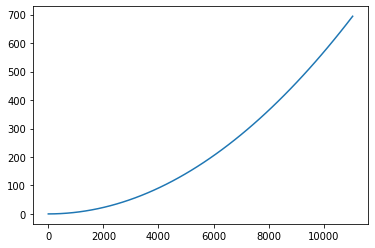

In [97]:
plt.plot(x0, z0)
plt.show()

In [98]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [99]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [100]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3]).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [106]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [107]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [108]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

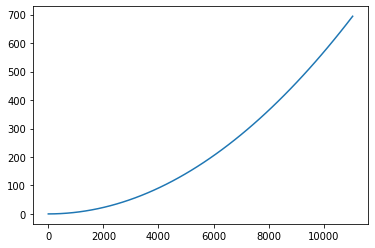

In [109]:
plt.plot(x0_, z0_)
plt.show()

In [370]:
init=1e-4
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
        q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*np.array([0.13 for x in range(node_N)])
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*np.array([-0.13 for x in range(node_N)])
#         q0[(j-1)*node_N]=0    
# q0[9*node_N-1]=init*0.13  # here

In [371]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [372]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [373]:
vehicle=semisub('DPcontrol',0,10,40.0,0,0) 

In [374]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [375]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

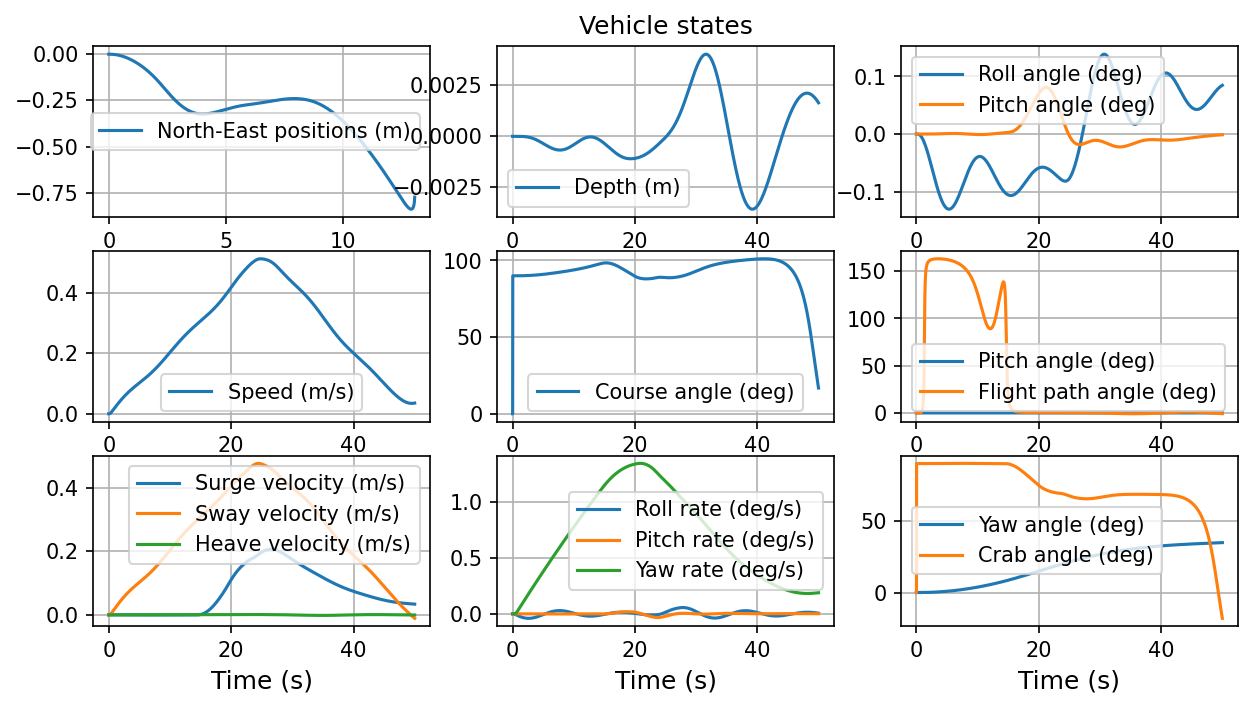

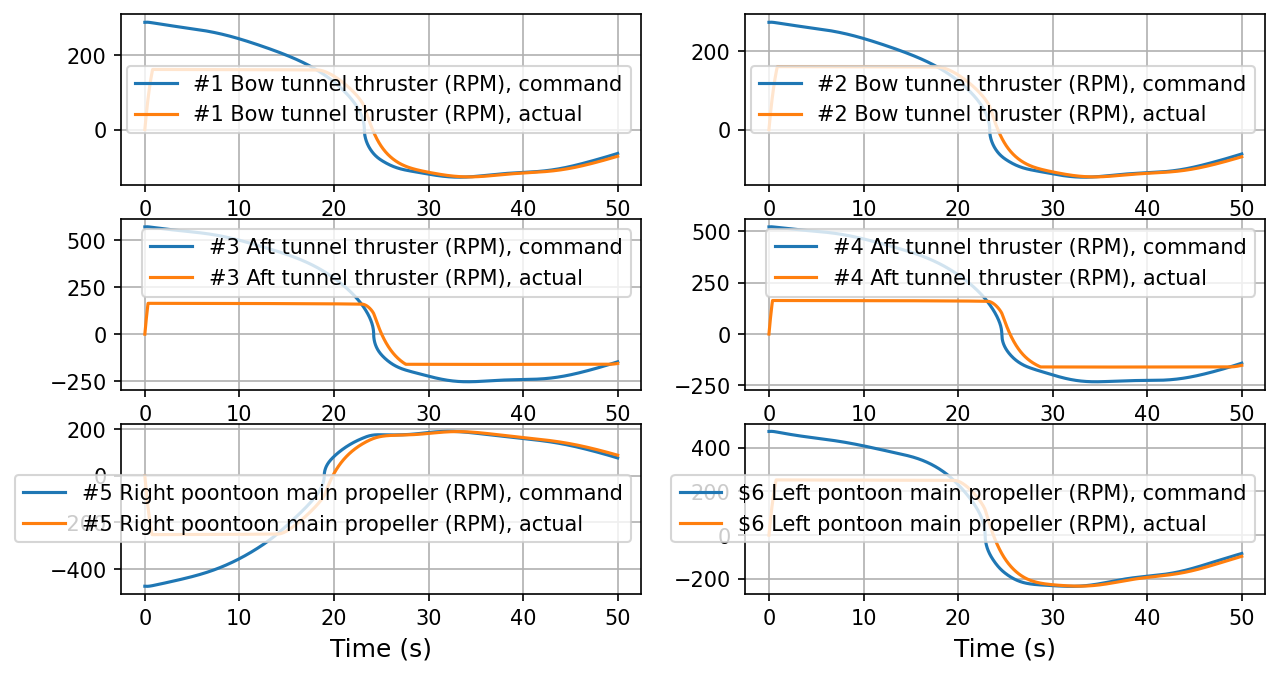

In [376]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [377]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

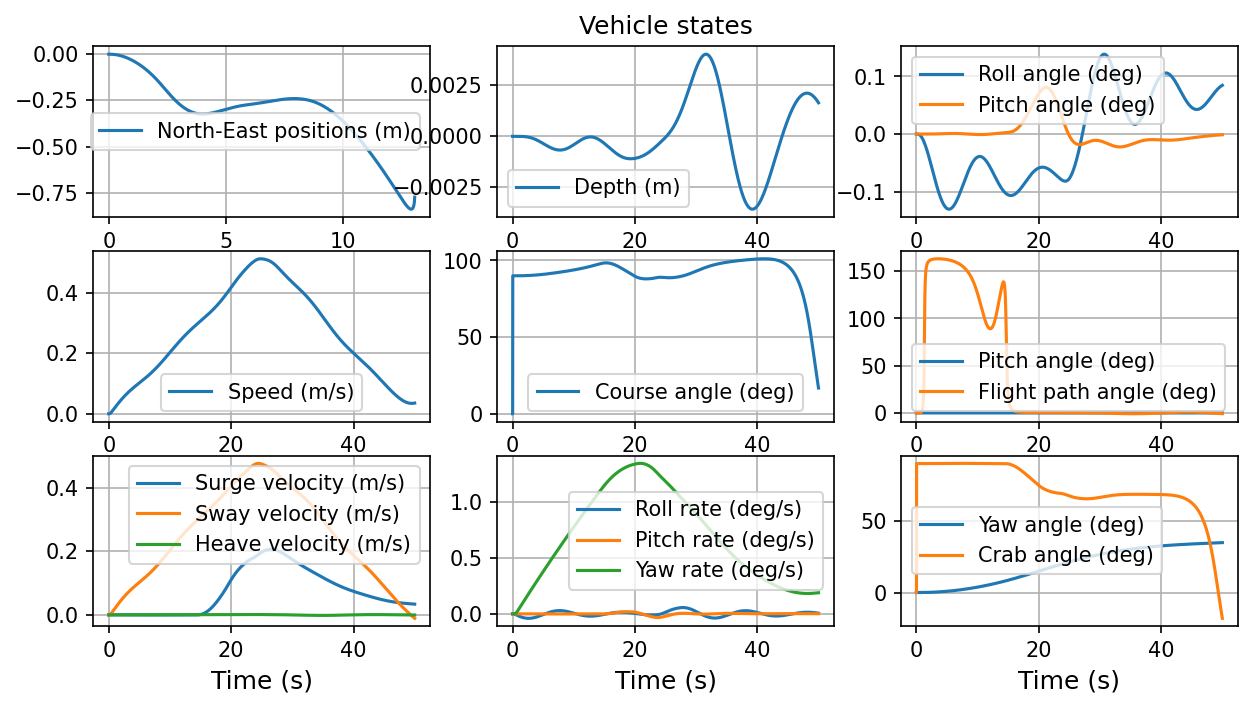

In [378]:
plotVehicleStates(simTime, simData, 3)

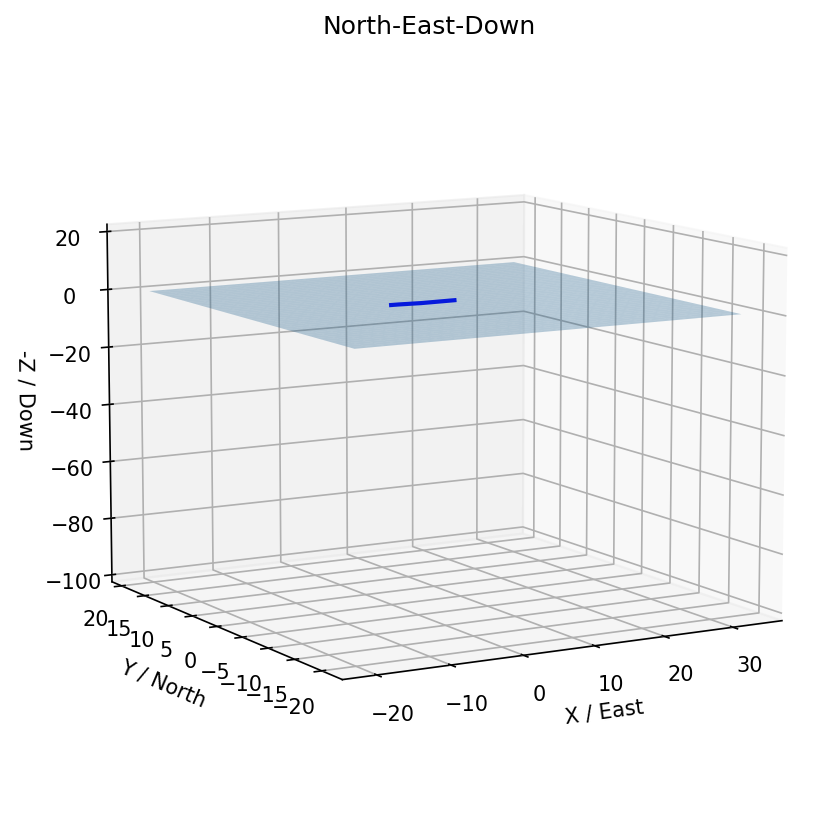

In [379]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [380]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [381]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [382]:
ssa(simData[:, 4][0+10])

4.440892098500626e-16

### Dynamics

In [383]:
def grayscott1d(t, Q): # here
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]

    
    Z0=np.dot(Re_b(Ret.astype(np.float32)),tau_force[:3].astype(np.float32)).astype(np.float32)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3]).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 #+Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                             ,RRRR),
                                   Z).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
   

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    
    hack=1e20
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [384]:
tspan = (0., 1)

In [385]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0.0
[[2.5672705e+05 1.9581678e+07 1.3670176e+08]
 [2.7299950e+05 1.9581690e+07 1.3670173e+08]
 [2.5516467e+05 1.9581680e+07 1.3670176e+08]
 [2.6730000e+05 1.9581690e+07 1.3670174e+08]
 [2.6924981e+05 1.9581656e+07 1.3670174e+08]
 [2.7218619e+05 1.9581700e+07 1.3670173e+08]
 [2.4330106e+05 1.9581714e+07 1.3670178e+08]
 [2.5383078e+05 1.9581624e+07 1.3670178e+08]
 [2.6583941e+05 1.9581704e+07 1.3670174e+08]
 [2.6735034e+05 1.9581678e+07 1.3670174e+08]
 [2.7649466e+05 1.9581676e+07 1.3670173e+08]
 [2.5399480e+05 1.9581672e+07 1.3670176e+08]
 [2.5778809e+05 1.9581670e+07 1.3670176e+08]
 [2.4657648e+05 1.9581684e+07 1.3670178e+08]
 [2.5456791e+05 1.9581670e+07 1.3670176e+08]
 [2.8095547e+05 1.9581612e+07 1.3670173e+08]
 [2.5563853e+05 1.9581696e+07 1.3670176e+08]
 [2.6400647e+05 1.9581682e+07 1.3670174e+08]
 [2.5483867e+05 1.9581696e+07 1.3670176e+08]
 [2.5629703e+05 1.9581632e+07 1.3670176e+08]
 [2.5570500e+05 1.9581690e+07 1.3670176e+08]
 [2.5775020e+05 1.9581660e+07 1.3670176e+08]
 [2.41

5.6746856781082105e-05
[[2.5672705e+05 1.9604966e+07 1.3676219e+08]
 [2.7300603e+05 1.9604978e+07 1.3676216e+08]
 [2.5516384e+05 1.9604968e+07 1.3676219e+08]
 [2.6730397e+05 1.9604978e+07 1.3676218e+08]
 [2.6925656e+05 1.9604944e+07 1.3676218e+08]
 [2.7219175e+05 1.9604988e+07 1.3676216e+08]
 [2.4329302e+05 1.9605002e+07 1.3676221e+08]
 [2.5383262e+05 1.9604912e+07 1.3676221e+08]
 [2.6584197e+05 1.9604992e+07 1.3676218e+08]
 [2.6735506e+05 1.9604966e+07 1.3676218e+08]
 [2.7650347e+05 1.9604964e+07 1.3676216e+08]
 [2.5399394e+05 1.9604960e+07 1.3676219e+08]
 [2.5778905e+05 1.9604958e+07 1.3676219e+08]
 [2.4657159e+05 1.9604972e+07 1.3676221e+08]
 [2.5456747e+05 1.9604958e+07 1.3676219e+08]
 [2.8096978e+05 1.9604900e+07 1.3676216e+08]
 [2.5563703e+05 1.9604984e+07 1.3676219e+08]
 [2.6400944e+05 1.9604970e+07 1.3676218e+08]
 [2.5483684e+05 1.9604984e+07 1.3676219e+08]
 [2.5629950e+05 1.9604920e+07 1.3676219e+08]
 [2.5570380e+05 1.9604978e+07 1.3676219e+08]
 [2.5775166e+05 1.9604948e+07 1.

[[2.5672705e+05 1.9625924e+07 1.3681658e+08]
 [2.7301188e+05 1.9625936e+07 1.3681654e+08]
 [2.5516311e+05 1.9625926e+07 1.3681658e+08]
 [2.6730750e+05 1.9625936e+07 1.3681656e+08]
 [2.6926262e+05 1.9625902e+07 1.3681656e+08]
 [2.7219675e+05 1.9625946e+07 1.3681654e+08]
 [2.4328580e+05 1.9625960e+07 1.3681659e+08]
 [2.5383427e+05 1.9625870e+07 1.3681659e+08]
 [2.6584428e+05 1.9625950e+07 1.3681656e+08]
 [2.6735931e+05 1.9625924e+07 1.3681656e+08]
 [2.7651138e+05 1.9625922e+07 1.3681654e+08]
 [2.5399316e+05 1.9625918e+07 1.3681658e+08]
 [2.5778992e+05 1.9625916e+07 1.3681658e+08]
 [2.4656720e+05 1.9625930e+07 1.3681659e+08]
 [2.5456706e+05 1.9625916e+07 1.3681658e+08]
 [2.8098269e+05 1.9625858e+07 1.3681654e+08]
 [2.5563567e+05 1.9625942e+07 1.3681658e+08]
 [2.6401209e+05 1.9625928e+07 1.3681656e+08]
 [2.5483519e+05 1.9625942e+07 1.3681658e+08]
 [2.5630173e+05 1.9625878e+07 1.3681658e+08]
 [2.5570273e+05 1.9625936e+07 1.3681658e+08]
 [2.5775297e+05 1.9625906e+07 1.3681658e+08]
 [2.415898

[[2.5672705e+05 1.9642226e+07 1.3685886e+08]
 [2.7301644e+05 1.9642238e+07 1.3685883e+08]
 [2.5516253e+05 1.9642228e+07 1.3685886e+08]
 [2.6731025e+05 1.9642238e+07 1.3685885e+08]
 [2.6926738e+05 1.9642204e+07 1.3685885e+08]
 [2.7220062e+05 1.9642248e+07 1.3685883e+08]
 [2.4328017e+05 1.9642262e+07 1.3685888e+08]
 [2.5383556e+05 1.9642172e+07 1.3685888e+08]
 [2.6584606e+05 1.9642252e+07 1.3685885e+08]
 [2.6736262e+05 1.9642226e+07 1.3685885e+08]
 [2.7651756e+05 1.9642224e+07 1.3685883e+08]
 [2.5399255e+05 1.9642220e+07 1.3685886e+08]
 [2.5779059e+05 1.9642218e+07 1.3685886e+08]
 [2.4656378e+05 1.9642232e+07 1.3685888e+08]
 [2.5456675e+05 1.9642218e+07 1.3685886e+08]
 [2.8099269e+05 1.9642160e+07 1.3685883e+08]
 [2.5563462e+05 1.9642244e+07 1.3685886e+08]
 [2.6401419e+05 1.9642230e+07 1.3685885e+08]
 [2.5483391e+05 1.9642244e+07 1.3685886e+08]
 [2.5630347e+05 1.9642180e+07 1.3685886e+08]
 [2.5570189e+05 1.9642238e+07 1.3685886e+08]
 [2.5775398e+05 1.9642208e+07 1.3685886e+08]
 [2.415843

[[2.5672706e+05 1.9665336e+07 1.3691898e+08]
 [2.7302297e+05 1.9665348e+07 1.3691894e+08]
 [2.5516173e+05 1.9665338e+07 1.3691898e+08]
 [2.6731422e+05 1.9665348e+07 1.3691896e+08]
 [2.6927409e+05 1.9665314e+07 1.3691896e+08]
 [2.7220619e+05 1.9665358e+07 1.3691894e+08]
 [2.4327220e+05 1.9665372e+07 1.3691899e+08]
 [2.5383739e+05 1.9665282e+07 1.3691899e+08]
 [2.6584866e+05 1.9665362e+07 1.3691896e+08]
 [2.6736734e+05 1.9665336e+07 1.3691896e+08]
 [2.7652634e+05 1.9665334e+07 1.3691894e+08]
 [2.5399170e+05 1.9665330e+07 1.3691898e+08]
 [2.5779156e+05 1.9665328e+07 1.3691898e+08]
 [2.4655895e+05 1.9665342e+07 1.3691899e+08]
 [2.5456631e+05 1.9665328e+07 1.3691898e+08]
 [2.8100694e+05 1.9665270e+07 1.3691894e+08]
 [2.5563314e+05 1.9665354e+07 1.3691898e+08]
 [2.6401712e+05 1.9665340e+07 1.3691896e+08]
 [2.5483211e+05 1.9665354e+07 1.3691898e+08]
 [2.5630594e+05 1.9665290e+07 1.3691898e+08]
 [2.5570073e+05 1.9665348e+07 1.3691898e+08]
 [2.5775545e+05 1.9665318e+07 1.3691898e+08]
 [2.415764

[[2.5672705e+05 1.9684060e+07 1.3696749e+08]
 [2.7302816e+05 1.9684072e+07 1.3696746e+08]
 [2.5516105e+05 1.9684062e+07 1.3696749e+08]
 [2.6731734e+05 1.9684072e+07 1.3696747e+08]
 [2.6927950e+05 1.9684038e+07 1.3696747e+08]
 [2.7221062e+05 1.9684082e+07 1.3696746e+08]
 [2.4326573e+05 1.9684096e+07 1.3696750e+08]
 [2.5383884e+05 1.9684006e+07 1.3696750e+08]
 [2.6585072e+05 1.9684086e+07 1.3696747e+08]
 [2.6737112e+05 1.9684060e+07 1.3696747e+08]
 [2.7653338e+05 1.9684058e+07 1.3696746e+08]
 [2.5399100e+05 1.9684054e+07 1.3696749e+08]
 [2.5779233e+05 1.9684052e+07 1.3696749e+08]
 [2.4655502e+05 1.9684066e+07 1.3696750e+08]
 [2.5456595e+05 1.9684052e+07 1.3696749e+08]
 [2.8101844e+05 1.9683994e+07 1.3696746e+08]
 [2.5563192e+05 1.9684078e+07 1.3696749e+08]
 [2.6401950e+05 1.9684064e+07 1.3696747e+08]
 [2.5483062e+05 1.9684078e+07 1.3696749e+08]
 [2.5630792e+05 1.9684014e+07 1.3696749e+08]
 [2.5569977e+05 1.9684072e+07 1.3696749e+08]
 [2.5775661e+05 1.9684042e+07 1.3696749e+08]
 [2.415701

0.07652669284315464
[[2.5672716e+05 1.9704292e+07 1.3702056e+08]
 [2.7303403e+05 1.9704304e+07 1.3702053e+08]
 [2.5516044e+05 1.9704294e+07 1.3702056e+08]
 [2.6732094e+05 1.9704304e+07 1.3702054e+08]
 [2.6928553e+05 1.9704270e+07 1.3702054e+08]
 [2.7221566e+05 1.9704314e+07 1.3702053e+08]
 [2.4325881e+05 1.9704328e+07 1.3702058e+08]
 [2.5384053e+05 1.9704238e+07 1.3702058e+08]
 [2.6585309e+05 1.9704318e+07 1.3702054e+08]
 [2.6737538e+05 1.9704292e+07 1.3702054e+08]
 [2.7654122e+05 1.9704290e+07 1.3702053e+08]
 [2.5399034e+05 1.9704286e+07 1.3702056e+08]
 [2.5779328e+05 1.9704284e+07 1.3702056e+08]
 [2.4655084e+05 1.9704298e+07 1.3702058e+08]
 [2.5456566e+05 1.9704284e+07 1.3702056e+08]
 [2.8103106e+05 1.9704226e+07 1.3702053e+08]
 [2.5563072e+05 1.9704310e+07 1.3702056e+08]
 [2.6402222e+05 1.9704296e+07 1.3702054e+08]
 [2.5482914e+05 1.9704310e+07 1.3702056e+08]
 [2.5631017e+05 1.9704246e+07 1.3702056e+08]
 [2.5569883e+05 1.9704304e+07 1.3702056e+08]
 [2.5775798e+05 1.9704274e+07 1.370

0.1183832506095729
[[2.5672761e+05 1.9725544e+07 1.3707736e+08]
 [2.7304062e+05 1.9725556e+07 1.3707733e+08]
 [2.5516012e+05 1.9725546e+07 1.3707736e+08]
 [2.6732512e+05 1.9725556e+07 1.3707734e+08]
 [2.6929228e+05 1.9725522e+07 1.3707734e+08]
 [2.7222138e+05 1.9725566e+07 1.3707733e+08]
 [2.4325181e+05 1.9725580e+07 1.3707738e+08]
 [2.5384256e+05 1.9725490e+07 1.3707738e+08]
 [2.6585603e+05 1.9725570e+07 1.3707734e+08]
 [2.6738028e+05 1.9725544e+07 1.3707734e+08]
 [2.7654997e+05 1.9725542e+07 1.3707733e+08]
 [2.5398997e+05 1.9725538e+07 1.3707736e+08]
 [2.5779461e+05 1.9725536e+07 1.3707736e+08]
 [2.4654672e+05 1.9725550e+07 1.3707738e+08]
 [2.5456567e+05 1.9725536e+07 1.3707736e+08]
 [2.8104481e+05 1.9725478e+07 1.3707733e+08]
 [2.5562981e+05 1.9725562e+07 1.3707736e+08]
 [2.6402547e+05 1.9725548e+07 1.3707734e+08]
 [2.5482791e+05 1.9725562e+07 1.3707736e+08]
 [2.5631284e+05 1.9725498e+07 1.3707736e+08]
 [2.5569820e+05 1.9725556e+07 1.3707736e+08]
 [2.5775977e+05 1.9725526e+07 1.3707

[[2.5672881e+05 1.9735584e+07 1.3710661e+08]
 [2.7304503e+05 1.9735596e+07 1.3710658e+08]
 [2.5516094e+05 1.9735586e+07 1.3710661e+08]
 [2.6732831e+05 1.9735596e+07 1.3710659e+08]
 [2.6929666e+05 1.9735562e+07 1.3710659e+08]
 [2.7222538e+05 1.9735606e+07 1.3710658e+08]
 [2.4324930e+05 1.9735620e+07 1.3710662e+08]
 [2.5384441e+05 1.9735530e+07 1.3710662e+08]
 [2.6585859e+05 1.9735610e+07 1.3710659e+08]
 [2.6738375e+05 1.9735584e+07 1.3710659e+08]
 [2.7655541e+05 1.9735582e+07 1.3710658e+08]
 [2.5399073e+05 1.9735578e+07 1.3710661e+08]
 [2.5779623e+05 1.9735576e+07 1.3710661e+08]
 [2.4654559e+05 1.9735590e+07 1.3710662e+08]
 [2.5456661e+05 1.9735576e+07 1.3710661e+08]
 [2.8105266e+05 1.9735518e+07 1.3710658e+08]
 [2.5563038e+05 1.9735602e+07 1.3710661e+08]
 [2.6402812e+05 1.9735588e+07 1.3710659e+08]
 [2.5482831e+05 1.9735602e+07 1.3710661e+08]
 [2.5631502e+05 1.9735538e+07 1.3710661e+08]
 [2.5569889e+05 1.9735596e+07 1.3710661e+08]
 [2.5776158e+05 1.9735566e+07 1.3710661e+08]
 [2.415538

 [2.6078006e+05 1.9758878e+07 1.3716702e+08]]
0.16809085653446637
[[2.5672928e+05 1.9759860e+07 1.3717069e+08]
 [2.7305244e+05 1.9759872e+07 1.3717066e+08]
 [2.5516055e+05 1.9759862e+07 1.3717069e+08]
 [2.6733297e+05 1.9759872e+07 1.3717067e+08]
 [2.6930425e+05 1.9759838e+07 1.3717067e+08]
 [2.7223178e+05 1.9759882e+07 1.3717066e+08]
 [2.4324131e+05 1.9759896e+07 1.3717070e+08]
 [2.5384672e+05 1.9759806e+07 1.3717070e+08]
 [2.6586184e+05 1.9759886e+07 1.3717067e+08]
 [2.6738922e+05 1.9759860e+07 1.3717067e+08]
 [2.7656522e+05 1.9759858e+07 1.3717066e+08]
 [2.5399027e+05 1.9759854e+07 1.3717069e+08]
 [2.5779772e+05 1.9759852e+07 1.3717069e+08]
 [2.4654091e+05 1.9759866e+07 1.3717070e+08]
 [2.5456659e+05 1.9759852e+07 1.3717069e+08]
 [2.8106819e+05 1.9759794e+07 1.3717066e+08]
 [2.5562928e+05 1.9759878e+07 1.3717069e+08]
 [2.6403175e+05 1.9759864e+07 1.3717067e+08]
 [2.5482688e+05 1.9759878e+07 1.3717069e+08]
 [2.5631803e+05 1.9759814e+07 1.3717069e+08]
 [2.5569811e+05 1.9759872e+07 1.37

[[2.5673314e+05 1.9771602e+07 1.3720866e+08]
 [2.7306053e+05 1.9771614e+07 1.3720862e+08]
 [2.5516391e+05 1.9771604e+07 1.3720866e+08]
 [2.6733947e+05 1.9771614e+07 1.3720864e+08]
 [2.6931212e+05 1.9771580e+07 1.3720864e+08]
 [2.7223938e+05 1.9771624e+07 1.3720862e+08]
 [2.4324053e+05 1.9771638e+07 1.3720867e+08]
 [2.5385112e+05 1.9771548e+07 1.3720867e+08]
 [2.6586759e+05 1.9771628e+07 1.3720864e+08]
 [2.6739606e+05 1.9771602e+07 1.3720864e+08]
 [2.7657459e+05 1.9771600e+07 1.3720862e+08]
 [2.5399352e+05 1.9771596e+07 1.3720866e+08]
 [2.5780208e+05 1.9771594e+07 1.3720866e+08]
 [2.4654177e+05 1.9771608e+07 1.3720867e+08]
 [2.5457008e+05 1.9771594e+07 1.3720866e+08]
 [2.8108034e+05 1.9771536e+07 1.3720862e+08]
 [2.5563239e+05 1.9771620e+07 1.3720866e+08]
 [2.6403753e+05 1.9771606e+07 1.3720864e+08]
 [2.5482978e+05 1.9771620e+07 1.3720866e+08]
 [2.5632292e+05 1.9771556e+07 1.3720866e+08]
 [2.5570138e+05 1.9771614e+07 1.3720866e+08]
 [2.5776814e+05 1.9771584e+07 1.3720866e+08]
 [2.415450

0.2406191686592861
[[2.5673559e+05 1.9792232e+07 1.3726624e+08]
 [2.7306928e+05 1.9792244e+07 1.3726621e+08]
 [2.5516559e+05 1.9792234e+07 1.3726624e+08]
 [2.6734575e+05 1.9792244e+07 1.3726622e+08]
 [2.6932088e+05 1.9792210e+07 1.3726622e+08]
 [2.7224725e+05 1.9792254e+07 1.3726621e+08]
 [2.4323556e+05 1.9792268e+07 1.3726626e+08]
 [2.5385500e+05 1.9792178e+07 1.3726626e+08]
 [2.6587266e+05 1.9792258e+07 1.3726622e+08]
 [2.6740300e+05 1.9792232e+07 1.3726622e+08]
 [2.7658544e+05 1.9792230e+07 1.3726621e+08]
 [2.5399511e+05 1.9792226e+07 1.3726624e+08]
 [2.5780541e+05 1.9792224e+07 1.3726624e+08]
 [2.4653961e+05 1.9792238e+07 1.3726626e+08]
 [2.5457205e+05 1.9792224e+07 1.3726624e+08]
 [2.8109606e+05 1.9792166e+07 1.3726621e+08]
 [2.5563352e+05 1.9792250e+07 1.3726624e+08]
 [2.6404281e+05 1.9792236e+07 1.3726622e+08]
 [2.5483059e+05 1.9792250e+07 1.3726624e+08]
 [2.5632745e+05 1.9792186e+07 1.3726624e+08]
 [2.5570277e+05 1.9792244e+07 1.3726624e+08]
 [2.5777188e+05 1.9792214e+07 1.3726

[[2.5673870e+05 1.9802736e+07 1.3729821e+08]
 [2.7307591e+05 1.9802748e+07 1.3729818e+08]
 [2.5516828e+05 1.9802738e+07 1.3729821e+08]
 [2.6735103e+05 1.9802748e+07 1.3729819e+08]
 [2.6932741e+05 1.9802714e+07 1.3729819e+08]
 [2.7225347e+05 1.9802758e+07 1.3729818e+08]
 [2.4323467e+05 1.9802772e+07 1.3729822e+08]
 [2.5385869e+05 1.9802682e+07 1.3729822e+08]
 [2.6587731e+05 1.9802762e+07 1.3729819e+08]
 [2.6740859e+05 1.9802736e+07 1.3729819e+08]
 [2.7659319e+05 1.9802734e+07 1.3729818e+08]
 [2.5399772e+05 1.9802730e+07 1.3729821e+08]
 [2.5780895e+05 1.9802728e+07 1.3729821e+08]
 [2.4654019e+05 1.9802742e+07 1.3729822e+08]
 [2.5457486e+05 1.9802728e+07 1.3729821e+08]
 [2.8110628e+05 1.9802670e+07 1.3729818e+08]
 [2.5563597e+05 1.9802754e+07 1.3729821e+08]
 [2.6404753e+05 1.9802740e+07 1.3729819e+08]
 [2.5483286e+05 1.9802754e+07 1.3729821e+08]
 [2.5633155e+05 1.9802690e+07 1.3729821e+08]
 [2.5570534e+05 1.9802748e+07 1.3729821e+08]
 [2.5777564e+05 1.9802718e+07 1.3729821e+08]
 [2.415391

0.34441882279062613
[[2.5675964e+05 1.9796230e+07 1.3730725e+08]
 [2.7309828e+05 1.9796242e+07 1.3730722e+08]
 [2.5518919e+05 1.9796232e+07 1.3730725e+08]
 [2.6737306e+05 1.9796242e+07 1.3730723e+08]
 [2.6934853e+05 1.9796208e+07 1.3730723e+08]
 [2.7227612e+05 1.9796252e+07 1.3730722e+08]
 [2.4325584e+05 1.9796266e+07 1.3730726e+08]
 [2.5387777e+05 1.9796176e+07 1.3730726e+08]
 [2.6589962e+05 1.9796256e+07 1.3730723e+08]
 [2.6743022e+05 1.9796230e+07 1.3730723e+08]
 [2.7661541e+05 1.9796228e+07 1.3730722e+08]
 [2.5401830e+05 1.9796224e+07 1.3730725e+08]
 [2.5782970e+05 1.9796222e+07 1.3730725e+08]
 [2.4656067e+05 1.9796236e+07 1.3730726e+08]
 [2.5459538e+05 1.9796222e+07 1.3730725e+08]
 [2.8112691e+05 1.9796164e+07 1.3730722e+08]
 [2.5565738e+05 1.9796248e+07 1.3730725e+08]
 [2.6406909e+05 1.9796234e+07 1.3730723e+08]
 [2.5485420e+05 1.9796248e+07 1.3730725e+08]
 [2.5635103e+05 1.9796184e+07 1.3730725e+08]
 [2.5572661e+05 1.9796242e+07 1.3730725e+08]
 [2.5779611e+05 1.9796212e+07 1.373

[[2.5675617e+05 1.9824330e+07 1.3737650e+08]
 [2.7310222e+05 1.9824342e+07 1.3737646e+08]
 [2.5518477e+05 1.9824332e+07 1.3737650e+08]
 [2.6737403e+05 1.9824342e+07 1.3737648e+08]
 [2.6935294e+05 1.9824308e+07 1.3737648e+08]
 [2.7227888e+05 1.9824352e+07 1.3737646e+08]
 [2.4324297e+05 1.9824366e+07 1.3737651e+08]
 [2.5387670e+05 1.9824276e+07 1.3737651e+08]
 [2.6589897e+05 1.9824356e+07 1.3737648e+08]
 [2.6743219e+05 1.9824330e+07 1.3737648e+08]
 [2.7662203e+05 1.9824328e+07 1.3737646e+08]
 [2.5401388e+05 1.9824324e+07 1.3737650e+08]
 [2.5782739e+05 1.9824322e+07 1.3737650e+08]
 [2.4655156e+05 1.9824336e+07 1.3737651e+08]
 [2.5459145e+05 1.9824322e+07 1.3737650e+08]
 [2.8114019e+05 1.9824264e+07 1.3737646e+08]
 [2.5565208e+05 1.9824348e+07 1.3737650e+08]
 [2.6406900e+05 1.9824334e+07 1.3737648e+08]
 [2.5484853e+05 1.9824348e+07 1.3737650e+08]
 [2.5635066e+05 1.9824284e+07 1.3737650e+08]
 [2.5572170e+05 1.9824342e+07 1.3737650e+08]
 [2.5779441e+05 1.9824312e+07 1.3737650e+08]
 [2.415471

0.3897595262274558
[[2.5678286e+05 1.9819492e+07 1.3737261e+08]
 [2.7312866e+05 1.9819504e+07 1.3737258e+08]
 [2.5521153e+05 1.9819494e+07 1.3737261e+08]
 [2.6740062e+05 1.9819504e+07 1.3737259e+08]
 [2.6937891e+05 1.9819470e+07 1.3737259e+08]
 [2.7230550e+05 1.9819514e+07 1.3737258e+08]
 [2.4327066e+05 1.9819528e+07 1.3737262e+08]
 [2.5390256e+05 1.9819438e+07 1.3737262e+08]
 [2.6592581e+05 1.9819518e+07 1.3737259e+08]
 [2.6745856e+05 1.9819492e+07 1.3737259e+08]
 [2.7664816e+05 1.9819490e+07 1.3737258e+08]
 [2.5404053e+05 1.9819486e+07 1.3737261e+08]
 [2.5785389e+05 1.9819484e+07 1.3737261e+08]
 [2.4657866e+05 1.9819498e+07 1.3737262e+08]
 [2.5461805e+05 1.9819484e+07 1.3737261e+08]
 [2.8116512e+05 1.9819426e+07 1.3737258e+08]
 [2.5567909e+05 1.9819510e+07 1.3737261e+08]
 [2.6409553e+05 1.9819496e+07 1.3737259e+08]
 [2.5487556e+05 1.9819510e+07 1.3737261e+08]
 [2.5637658e+05 1.9819446e+07 1.3737261e+08]
 [2.5574862e+05 1.9819504e+07 1.3737261e+08]
 [2.5782077e+05 1.9819474e+07 1.3737

[[2.5679575e+05 1.9834586e+07 1.3740269e+08]
 [2.7314462e+05 1.9834598e+07 1.3740266e+08]
 [2.5522398e+05 1.9834588e+07 1.3740269e+08]
 [2.6741531e+05 1.9834598e+07 1.3740267e+08]
 [2.6939544e+05 1.9834564e+07 1.3740267e+08]
 [2.7232088e+05 1.9834608e+07 1.3740266e+08]
 [2.4327905e+05 1.9834622e+07 1.3740270e+08]
 [2.5391711e+05 1.9834532e+07 1.3740270e+08]
 [2.6593962e+05 1.9834612e+07 1.3740267e+08]
 [2.6747381e+05 1.9834586e+07 1.3740267e+08]
 [2.7666544e+05 1.9834584e+07 1.3740266e+08]
 [2.5405308e+05 1.9834580e+07 1.3740269e+08]
 [2.5786739e+05 1.9834578e+07 1.3740269e+08]
 [2.4658903e+05 1.9834592e+07 1.3740270e+08]
 [2.5463084e+05 1.9834578e+07 1.3740269e+08]
 [2.8118600e+05 1.9834520e+07 1.3740266e+08]
 [2.5569100e+05 1.9834604e+07 1.3740269e+08]
 [2.6410984e+05 1.9834590e+07 1.3740267e+08]
 [2.5488731e+05 1.9834604e+07 1.3740269e+08]
 [2.5639134e+05 1.9834540e+07 1.3740269e+08]
 [2.5576075e+05 1.9834598e+07 1.3740269e+08]
 [2.5783462e+05 1.9834568e+07 1.3740269e+08]
 [2.415832

0.469593590539493
[[2.5685286e+05 1.9828342e+07 1.3731344e+08]
 [2.7319081e+05 1.9828354e+07 1.3731341e+08]
 [2.5528206e+05 1.9828344e+07 1.3731344e+08]
 [2.6746519e+05 1.9828354e+07 1.3731342e+08]
 [2.6944494e+05 1.9828320e+07 1.3731342e+08]
 [2.7236731e+05 1.9828364e+07 1.3731341e+08]
 [2.4334397e+05 1.9828378e+07 1.3731346e+08]
 [2.5397752e+05 1.9828288e+07 1.3731346e+08]
 [2.6599016e+05 1.9828368e+07 1.3731342e+08]
 [2.6752400e+05 1.9828342e+07 1.3731342e+08]
 [2.7670966e+05 1.9828340e+07 1.3731341e+08]
 [2.5411212e+05 1.9828336e+07 1.3731344e+08]
 [2.5792403e+05 1.9828334e+07 1.3731344e+08]
 [2.4665258e+05 1.9828348e+07 1.3731346e+08]
 [2.5468958e+05 1.9828334e+07 1.3731344e+08]
 [2.8122891e+05 1.9828276e+07 1.3731341e+08]
 [2.5574836e+05 1.9828360e+07 1.3731344e+08]
 [2.6416209e+05 1.9828346e+07 1.3731342e+08]
 [2.5494520e+05 1.9828360e+07 1.3731344e+08]
 [2.5644992e+05 1.9828296e+07 1.3731344e+08]
 [2.5581820e+05 1.9828354e+07 1.3731344e+08]
 [2.5789152e+05 1.9828324e+07 1.37313

0.4800938252855553
[[2.5686591e+05 1.9846274e+07 1.3734096e+08]
 [2.7320650e+05 1.9846286e+07 1.3734093e+08]
 [2.5529467e+05 1.9846276e+07 1.3734096e+08]
 [2.6747969e+05 1.9846286e+07 1.3734094e+08]
 [2.6946166e+05 1.9846252e+07 1.3734094e+08]
 [2.7238225e+05 1.9846296e+07 1.3734093e+08]
 [2.4335231e+05 1.9846310e+07 1.3734098e+08]
 [2.5399295e+05 1.9846220e+07 1.3734098e+08]
 [2.6600362e+05 1.9846300e+07 1.3734094e+08]
 [2.6753919e+05 1.9846274e+07 1.3734094e+08]
 [2.7672675e+05 1.9846272e+07 1.3734093e+08]
 [2.5412495e+05 1.9846268e+07 1.3734096e+08]
 [2.5793775e+05 1.9846266e+07 1.3734096e+08]
 [2.4666322e+05 1.9846280e+07 1.3734098e+08]
 [2.5470269e+05 1.9846266e+07 1.3734096e+08]
 [2.8125028e+05 1.9846208e+07 1.3734093e+08]
 [2.5576020e+05 1.9846292e+07 1.3734096e+08]
 [2.6417638e+05 1.9846278e+07 1.3734094e+08]
 [2.5495692e+05 1.9846292e+07 1.3734096e+08]
 [2.5646544e+05 1.9846228e+07 1.3734096e+08]
 [2.5583033e+05 1.9846286e+07 1.3734096e+08]
 [2.5790573e+05 1.9846256e+07 1.3734

0.5117645892894159
[[2.5691189e+05 1.9848768e+07 1.3727832e+08]
 [2.7324450e+05 1.9848780e+07 1.3727829e+08]
 [2.5534127e+05 1.9848770e+07 1.3727832e+08]
 [2.6752025e+05 1.9848780e+07 1.3727830e+08]
 [2.6950288e+05 1.9848746e+07 1.3727830e+08]
 [2.7242016e+05 1.9848790e+07 1.3727829e+08]
 [2.4340280e+05 1.9848804e+07 1.3727834e+08]
 [2.5404270e+05 1.9848714e+07 1.3727834e+08]
 [2.6604431e+05 1.9848794e+07 1.3727830e+08]
 [2.6758034e+05 1.9848768e+07 1.3727830e+08]
 [2.7676375e+05 1.9848766e+07 1.3727829e+08]
 [2.5417245e+05 1.9848762e+07 1.3727832e+08]
 [2.5798364e+05 1.9848760e+07 1.3727832e+08]
 [2.4671353e+05 1.9848774e+07 1.3727834e+08]
 [2.5475005e+05 1.9848760e+07 1.3727832e+08]
 [2.8128800e+05 1.9848702e+07 1.3727829e+08]
 [2.5580589e+05 1.9848786e+07 1.3727832e+08]
 [2.6421881e+05 1.9848772e+07 1.3727830e+08]
 [2.5500298e+05 1.9848786e+07 1.3727832e+08]
 [2.5651372e+05 1.9848722e+07 1.3727832e+08]
 [2.5587620e+05 1.9848780e+07 1.3727832e+08]
 [2.5795203e+05 1.9848750e+07 1.3727

0.5711875740175769
[[2.5704202e+05 1.9839446e+07 1.3706085e+08]
 [2.7334772e+05 1.9839458e+07 1.3706082e+08]
 [2.5547367e+05 1.9839448e+07 1.3706085e+08]
 [2.6763247e+05 1.9839458e+07 1.3706083e+08]
 [2.6961491e+05 1.9839424e+07 1.3706083e+08]
 [2.7252378e+05 1.9839468e+07 1.3706082e+08]
 [2.4355116e+05 1.9839482e+07 1.3706086e+08]
 [2.5418209e+05 1.9839392e+07 1.3706086e+08]
 [2.6615775e+05 1.9839472e+07 1.3706083e+08]
 [2.6769359e+05 1.9839446e+07 1.3706083e+08]
 [2.7686253e+05 1.9839444e+07 1.3706082e+08]
 [2.5430744e+05 1.9839440e+07 1.3706085e+08]
 [2.5811281e+05 1.9839438e+07 1.3706085e+08]
 [2.4685922e+05 1.9839452e+07 1.3706086e+08]
 [2.5488438e+05 1.9839438e+07 1.3706085e+08]
 [2.8138497e+05 1.9839380e+07 1.3706082e+08]
 [2.5593622e+05 1.9839464e+07 1.3706085e+08]
 [2.6433697e+05 1.9839450e+07 1.3706083e+08]
 [2.5513464e+05 1.9839464e+07 1.3706085e+08]
 [2.5664850e+05 1.9839400e+07 1.3706085e+08]
 [2.5600686e+05 1.9839458e+07 1.3706085e+08]
 [2.5808203e+05 1.9839428e+07 1.3706

[[2.5706977e+05 1.9854922e+07 1.3706155e+08]
 [2.7337484e+05 1.9854934e+07 1.3706152e+08]
 [2.5550128e+05 1.9854924e+07 1.3706155e+08]
 [2.6765950e+05 1.9854934e+07 1.3706154e+08]
 [2.6964400e+05 1.9854900e+07 1.3706154e+08]
 [2.7255028e+05 1.9854944e+07 1.3706152e+08]
 [2.4357662e+05 1.9854958e+07 1.3706157e+08]
 [2.5421309e+05 1.9854868e+07 1.3706157e+08]
 [2.6618403e+05 1.9854948e+07 1.3706154e+08]
 [2.6772144e+05 1.9854922e+07 1.3706154e+08]
 [2.7689044e+05 1.9854920e+07 1.3706152e+08]
 [2.5433553e+05 1.9854916e+07 1.3706155e+08]
 [2.5814109e+05 1.9854914e+07 1.3706155e+08]
 [2.4688650e+05 1.9854928e+07 1.3706157e+08]
 [2.5491264e+05 1.9854914e+07 1.3706155e+08]
 [2.8141662e+05 1.9854856e+07 1.3706152e+08]
 [2.5596289e+05 1.9854940e+07 1.3706155e+08]
 [2.6436450e+05 1.9854926e+07 1.3706154e+08]
 [2.5516133e+05 1.9854940e+07 1.3706155e+08]
 [2.5667906e+05 1.9854876e+07 1.3706155e+08]
 [2.5603383e+05 1.9854934e+07 1.3706155e+08]
 [2.5811084e+05 1.9854904e+07 1.3706155e+08]
 [2.418891

[[2.5723609e+05 1.9850624e+07 1.3682173e+08]
 [2.7351125e+05 1.9850636e+07 1.3682170e+08]
 [2.5567008e+05 1.9850626e+07 1.3682173e+08]
 [2.6780578e+05 1.9850636e+07 1.3682171e+08]
 [2.6979088e+05 1.9850602e+07 1.3682171e+08]
 [2.7268684e+05 1.9850646e+07 1.3682170e+08]
 [2.4376220e+05 1.9850660e+07 1.3682174e+08]
 [2.5439091e+05 1.9850570e+07 1.3682174e+08]
 [2.6633138e+05 1.9850650e+07 1.3682171e+08]
 [2.6786919e+05 1.9850624e+07 1.3682171e+08]
 [2.7702225e+05 1.9850622e+07 1.3682170e+08]
 [2.5450736e+05 1.9850618e+07 1.3682173e+08]
 [2.5830658e+05 1.9850616e+07 1.3682173e+08]
 [2.4706983e+05 1.9850630e+07 1.3682174e+08]
 [2.5508380e+05 1.9850616e+07 1.3682173e+08]
 [2.8154788e+05 1.9850558e+07 1.3682170e+08]
 [2.5612903e+05 1.9850642e+07 1.3682173e+08]
 [2.6451753e+05 1.9850628e+07 1.3682171e+08]
 [2.5532892e+05 1.9850642e+07 1.3682173e+08]
 [2.5685162e+05 1.9850578e+07 1.3682173e+08]
 [2.5620042e+05 1.9850636e+07 1.3682173e+08]
 [2.5827744e+05 1.9850606e+07 1.3682173e+08]
 [2.420795

0.6790783641353028
[[2.5745675e+05 1.9839026e+07 1.3651030e+08]
 [2.7369331e+05 1.9839038e+07 1.3651027e+08]
 [2.5589400e+05 1.9839028e+07 1.3651030e+08]
 [2.6800069e+05 1.9839038e+07 1.3651029e+08]
 [2.6998575e+05 1.9839004e+07 1.3651029e+08]
 [2.7286941e+05 1.9839048e+07 1.3651027e+08]
 [2.4400870e+05 1.9839062e+07 1.3651032e+08]
 [2.5462519e+05 1.9838972e+07 1.3651032e+08]
 [2.6652800e+05 1.9839052e+07 1.3651029e+08]
 [2.6806569e+05 1.9839026e+07 1.3651029e+08]
 [2.7719803e+05 1.9839024e+07 1.3651027e+08]
 [2.5473503e+05 1.9839020e+07 1.3651030e+08]
 [2.5852592e+05 1.9839018e+07 1.3651030e+08]
 [2.4731272e+05 1.9839032e+07 1.3651032e+08]
 [2.5531053e+05 1.9839018e+07 1.3651030e+08]
 [2.8172147e+05 1.9838960e+07 1.3651027e+08]
 [2.5634986e+05 1.9839044e+07 1.3651030e+08]
 [2.6472103e+05 1.9839030e+07 1.3651029e+08]
 [2.5555164e+05 1.9839044e+07 1.3651030e+08]
 [2.5707928e+05 1.9838980e+07 1.3651030e+08]
 [2.5642173e+05 1.9839040e+07 1.3651030e+08]
 [2.5849803e+05 1.9839008e+07 1.3651

0.6603391083426297
[[2.5736212e+05 1.9866518e+07 1.3670053e+08]
 [2.7362131e+05 1.9866530e+07 1.3670050e+08]
 [2.5579719e+05 1.9866520e+07 1.3670053e+08]
 [2.6792078e+05 1.9866530e+07 1.3670051e+08]
 [2.6990856e+05 1.9866496e+07 1.3670051e+08]
 [2.7279628e+05 1.9866540e+07 1.3670050e+08]
 [2.4389536e+05 1.9866554e+07 1.3670054e+08]
 [2.5452659e+05 1.9866464e+07 1.3670054e+08]
 [2.6644603e+05 1.9866544e+07 1.3670051e+08]
 [2.6798584e+05 1.9866518e+07 1.3670051e+08]
 [2.7713091e+05 1.9866516e+07 1.3670050e+08]
 [2.5463661e+05 1.9866512e+07 1.3670053e+08]
 [2.5843280e+05 1.9866510e+07 1.3670053e+08]
 [2.4720397e+05 1.9866524e+07 1.3670054e+08]
 [2.5521291e+05 1.9866510e+07 1.3670053e+08]
 [2.8166062e+05 1.9866452e+07 1.3670050e+08]
 [2.5625370e+05 1.9866536e+07 1.3670053e+08]
 [2.6463653e+05 1.9866522e+07 1.3670051e+08]
 [2.5545436e+05 1.9866536e+07 1.3670053e+08]
 [2.5698411e+05 1.9866472e+07 1.3670053e+08]
 [2.5632569e+05 1.9866532e+07 1.3670053e+08]
 [2.5840484e+05 1.9866500e+07 1.3670

0.6927882266625617
[[2.5750953e+05 1.9870660e+07 1.3652979e+08]
 [2.7374709e+05 1.9870672e+07 1.3652976e+08]
 [2.5594630e+05 1.9870662e+07 1.3652979e+08]
 [2.6805356e+05 1.9870672e+07 1.3652978e+08]
 [2.7004272e+05 1.9870638e+07 1.3652978e+08]
 [2.7292188e+05 1.9870682e+07 1.3652976e+08]
 [2.4405544e+05 1.9870696e+07 1.3652981e+08]
 [2.5468370e+05 1.9870606e+07 1.3652981e+08]
 [2.6657919e+05 1.9870686e+07 1.3652978e+08]
 [2.6812003e+05 1.9870660e+07 1.3652978e+08]
 [2.7725375e+05 1.9870658e+07 1.3652976e+08]
 [2.5478809e+05 1.9870654e+07 1.3652979e+08]
 [2.5857984e+05 1.9870652e+07 1.3652979e+08]
 [2.4736328e+05 1.9870666e+07 1.3652981e+08]
 [2.5536400e+05 1.9870652e+07 1.3652979e+08]
 [2.8178481e+05 1.9870594e+07 1.3652976e+08]
 [2.5640047e+05 1.9870678e+07 1.3652979e+08]
 [2.6477434e+05 1.9870664e+07 1.3652978e+08]
 [2.5560219e+05 1.9870678e+07 1.3652979e+08]
 [2.5713727e+05 1.9870614e+07 1.3652979e+08]
 [2.5647292e+05 1.9870674e+07 1.3652979e+08]
 [2.5855294e+05 1.9870642e+07 1.3652

0.7614978667039899
[[2.5794673e+05 1.9847302e+07 1.3597222e+08]
 [2.7411531e+05 1.9847314e+07 1.3597219e+08]
 [2.5638936e+05 1.9847304e+07 1.3597222e+08]
 [2.6844481e+05 1.9847314e+07 1.3597221e+08]
 [2.7043356e+05 1.9847280e+07 1.3597221e+08]
 [2.7329112e+05 1.9847324e+07 1.3597219e+08]
 [2.4453930e+05 1.9847340e+07 1.3597224e+08]
 [2.5514475e+05 1.9847248e+07 1.3597224e+08]
 [2.6697362e+05 1.9847328e+07 1.3597221e+08]
 [2.6851400e+05 1.9847302e+07 1.3597221e+08]
 [2.7761059e+05 1.9847300e+07 1.3597219e+08]
 [2.5523777e+05 1.9847296e+07 1.3597222e+08]
 [2.5901462e+05 1.9847294e+07 1.3597222e+08]
 [2.4784036e+05 1.9847308e+07 1.3597224e+08]
 [2.5581197e+05 1.9847294e+07 1.3597222e+08]
 [2.8213712e+05 1.9847236e+07 1.3597219e+08]
 [2.5683817e+05 1.9847320e+07 1.3597222e+08]
 [2.6518088e+05 1.9847306e+07 1.3597221e+08]
 [2.5604325e+05 1.9847320e+07 1.3597222e+08]
 [2.5758653e+05 1.9847254e+07 1.3597222e+08]
 [2.5691144e+05 1.9847316e+07 1.3597222e+08]
 [2.5898984e+05 1.9847284e+07 1.3597

0.7441605689203288
[[2.5780858e+05 1.9877316e+07 1.3620227e+08]
 [2.7400469e+05 1.9877328e+07 1.3620224e+08]
 [2.5624859e+05 1.9877318e+07 1.3620227e+08]
 [2.6832459e+05 1.9877328e+07 1.3620226e+08]
 [2.7031625e+05 1.9877294e+07 1.3620226e+08]
 [2.7317922e+05 1.9877338e+07 1.3620224e+08]
 [2.4437897e+05 1.9877352e+07 1.3620229e+08]
 [2.5500109e+05 1.9877262e+07 1.3620229e+08]
 [2.6685109e+05 1.9877342e+07 1.3620226e+08]
 [2.6839372e+05 1.9877316e+07 1.3620226e+08]
 [2.7750569e+05 1.9877314e+07 1.3620224e+08]
 [2.5509495e+05 1.9877310e+07 1.3620227e+08]
 [2.5887816e+05 1.9877308e+07 1.3620227e+08]
 [2.4768520e+05 1.9877322e+07 1.3620229e+08]
 [2.5567008e+05 1.9877308e+07 1.3620227e+08]
 [2.8203903e+05 1.9877250e+07 1.3620224e+08]
 [2.5669839e+05 1.9877334e+07 1.3620227e+08]
 [2.6505503e+05 1.9877320e+07 1.3620226e+08]
 [2.5590211e+05 1.9877334e+07 1.3620227e+08]
 [2.5744711e+05 1.9877268e+07 1.3620227e+08]
 [2.5677170e+05 1.9877330e+07 1.3620227e+08]
 [2.5885322e+05 1.9877298e+07 1.3620

[[2.5810078e+05 1.9875442e+07 1.3589136e+08]
 [2.7425791e+05 1.9875454e+07 1.3589133e+08]
 [2.5654397e+05 1.9875444e+07 1.3589136e+08]
 [2.6859062e+05 1.9875454e+07 1.3589134e+08]
 [2.7058353e+05 1.9875420e+07 1.3589134e+08]
 [2.7343256e+05 1.9875464e+07 1.3589133e+08]
 [2.4469558e+05 1.9875480e+07 1.3589138e+08]
 [2.5530897e+05 1.9875388e+07 1.3589138e+08]
 [2.6711831e+05 1.9875468e+07 1.3589134e+08]
 [2.6866184e+05 1.9875442e+07 1.3589134e+08]
 [2.7775316e+05 1.9875440e+07 1.3589133e+08]
 [2.5539436e+05 1.9875436e+07 1.3589136e+08]
 [2.5916939e+05 1.9875434e+07 1.3589136e+08]
 [2.4799934e+05 1.9875448e+07 1.3589138e+08]
 [2.5596867e+05 1.9875434e+07 1.3589136e+08]
 [2.8228662e+05 1.9875376e+07 1.3589133e+08]
 [2.5699008e+05 1.9875460e+07 1.3589136e+08]
 [2.6532994e+05 1.9875446e+07 1.3589134e+08]
 [2.5619570e+05 1.9875460e+07 1.3589136e+08]
 [2.5774808e+05 1.9875394e+07 1.3589136e+08]
 [2.5706408e+05 1.9875456e+07 1.3589136e+08]
 [2.5914602e+05 1.9875424e+07 1.3589136e+08]
 [2.430337

0.8461979066773769
[[2.5872797e+05 1.9853746e+07 1.3529509e+08]
 [2.7481119e+05 1.9853758e+07 1.3529506e+08]
 [2.5717739e+05 1.9853748e+07 1.3529509e+08]
 [2.6916850e+05 1.9853758e+07 1.3529507e+08]
 [2.7116141e+05 1.9853724e+07 1.3529507e+08]
 [2.7398675e+05 1.9853768e+07 1.3529506e+08]
 [2.4537219e+05 1.9853784e+07 1.3529510e+08]
 [2.5596236e+05 1.9853690e+07 1.3529510e+08]
 [2.6769941e+05 1.9853772e+07 1.3529507e+08]
 [2.6924281e+05 1.9853746e+07 1.3529507e+08]
 [2.7829441e+05 1.9853744e+07 1.3529506e+08]
 [2.5603497e+05 1.9853740e+07 1.3529509e+08]
 [2.5979409e+05 1.9853738e+07 1.3529509e+08]
 [2.4866909e+05 1.9853752e+07 1.3529510e+08]
 [2.5660748e+05 1.9853738e+07 1.3529509e+08]
 [2.8282384e+05 1.9853680e+07 1.3529506e+08]
 [2.5761756e+05 1.9853764e+07 1.3529509e+08]
 [2.6592425e+05 1.9853750e+07 1.3529507e+08]
 [2.5682680e+05 1.9853764e+07 1.3529509e+08]
 [2.5838877e+05 1.9853698e+07 1.3529509e+08]
 [2.5769252e+05 1.9853760e+07 1.3529509e+08]
 [2.5977312e+05 1.9853728e+07 1.3529

[[2.5844269e+05 1.9882706e+07 1.3560187e+08]
 [2.7456312e+05 1.9882718e+07 1.3560184e+08]
 [2.5688875e+05 1.9882708e+07 1.3560187e+08]
 [2.6890772e+05 1.9882718e+07 1.3560186e+08]
 [2.7090300e+05 1.9882684e+07 1.3560186e+08]
 [2.7373747e+05 1.9882728e+07 1.3560184e+08]
 [2.4505892e+05 1.9882744e+07 1.3560189e+08]
 [2.5566739e+05 1.9882650e+07 1.3560189e+08]
 [2.6743606e+05 1.9882732e+07 1.3560186e+08]
 [2.6898134e+05 1.9882706e+07 1.3560186e+08]
 [2.7805341e+05 1.9882704e+07 1.3560184e+08]
 [2.5574320e+05 1.9882700e+07 1.3560187e+08]
 [2.5951069e+05 1.9882698e+07 1.3560187e+08]
 [2.4836142e+05 1.9882712e+07 1.3560189e+08]
 [2.5631684e+05 1.9882698e+07 1.3560187e+08]
 [2.8258925e+05 1.9882640e+07 1.3560184e+08]
 [2.5733089e+05 1.9882724e+07 1.3560187e+08]
 [2.6565556e+05 1.9882710e+07 1.3560186e+08]
 [2.5653830e+05 1.9882724e+07 1.3560187e+08]
 [2.5809978e+05 1.9882658e+07 1.3560187e+08]
 [2.5740569e+05 1.9882720e+07 1.3560187e+08]
 [2.5948911e+05 1.9882688e+07 1.3560187e+08]
 [2.434036

[[2.5853600e+05 1.9886248e+07 1.3553389e+08]
 [2.7464775e+05 1.9886260e+07 1.3553386e+08]
 [2.5698272e+05 1.9886250e+07 1.3553389e+08]
 [2.6899509e+05 1.9886260e+07 1.3553387e+08]
 [2.7099119e+05 1.9886226e+07 1.3553387e+08]
 [2.7382194e+05 1.9886270e+07 1.3553386e+08]
 [2.4515702e+05 1.9886286e+07 1.3553390e+08]
 [2.5576497e+05 1.9886192e+07 1.3553390e+08]
 [2.6752353e+05 1.9886274e+07 1.3553387e+08]
 [2.6906941e+05 1.9886248e+07 1.3553387e+08]
 [2.7813697e+05 1.9886246e+07 1.3553386e+08]
 [2.5583819e+05 1.9886242e+07 1.3553389e+08]
 [2.5960392e+05 1.9886240e+07 1.3553389e+08]
 [2.4845944e+05 1.9886254e+07 1.3553390e+08]
 [2.5641169e+05 1.9886240e+07 1.3553389e+08]
 [2.8267378e+05 1.9886182e+07 1.3553386e+08]
 [2.5742381e+05 1.9886266e+07 1.3553389e+08]
 [2.6574503e+05 1.9886252e+07 1.3553387e+08]
 [2.5663164e+05 1.9886266e+07 1.3553389e+08]
 [2.5819573e+05 1.9886200e+07 1.3553389e+08]
 [2.5749884e+05 1.9886262e+07 1.3553389e+08]
 [2.5958281e+05 1.9886230e+07 1.3553389e+08]
 [2.435033

0.8881095913805945
[[2.5915709e+05 1.9874812e+07 1.3504059e+08]
 [2.7520738e+05 1.9874824e+07 1.3504056e+08]
 [2.5760891e+05 1.9874814e+07 1.3504059e+08]
 [2.6957509e+05 1.9874824e+07 1.3504058e+08]
 [2.7157203e+05 1.9874790e+07 1.3504058e+08]
 [2.7438209e+05 1.9874834e+07 1.3504056e+08]
 [2.4581806e+05 1.9874850e+07 1.3504061e+08]
 [2.5640914e+05 1.9874756e+07 1.3504061e+08]
 [2.6810584e+05 1.9874838e+07 1.3504058e+08]
 [2.6965225e+05 1.9874812e+07 1.3504058e+08]
 [2.7868700e+05 1.9874810e+07 1.3504056e+08]
 [2.5647053e+05 1.9874806e+07 1.3504059e+08]
 [2.6022319e+05 1.9874804e+07 1.3504059e+08]
 [2.4911556e+05 1.9874818e+07 1.3504061e+08]
 [2.5704264e+05 1.9874804e+07 1.3504059e+08]
 [2.8322206e+05 1.9874746e+07 1.3504056e+08]
 [2.5804470e+05 1.9874830e+07 1.3504059e+08]
 [2.6633884e+05 1.9874816e+07 1.3504058e+08]
 [2.5725552e+05 1.9874830e+07 1.3504059e+08]
 [2.5882919e+05 1.9874764e+07 1.3504059e+08]
 [2.5812062e+05 1.9874826e+07 1.3504059e+08]
 [2.6020428e+05 1.9874794e+07 1.3504

0.8926680275393477
[[2.5915934e+05 1.9893430e+07 1.3508893e+08]
 [2.7521484e+05 1.9893442e+07 1.3508890e+08]
 [2.5761050e+05 1.9893432e+07 1.3508893e+08]
 [2.6958050e+05 1.9893442e+07 1.3508891e+08]
 [2.7157969e+05 1.9893408e+07 1.3508891e+08]
 [2.7438878e+05 1.9893452e+07 1.3508890e+08]
 [2.4581388e+05 1.9893468e+07 1.3508894e+08]
 [2.5641284e+05 1.9893374e+07 1.3508894e+08]
 [2.6811016e+05 1.9893456e+07 1.3508891e+08]
 [2.6965828e+05 1.9893430e+07 1.3508891e+08]
 [2.7869631e+05 1.9893428e+07 1.3508890e+08]
 [2.5647209e+05 1.9893424e+07 1.3508893e+08]
 [2.6022620e+05 1.9893422e+07 1.3508893e+08]
 [2.4911391e+05 1.9893436e+07 1.3508894e+08]
 [2.5704453e+05 1.9893422e+07 1.3508893e+08]
 [2.8323575e+05 1.9893364e+07 1.3508890e+08]
 [2.5804575e+05 1.9893448e+07 1.3508893e+08]
 [2.6634347e+05 1.9893434e+07 1.3508891e+08]
 [2.5725630e+05 1.9893448e+07 1.3508893e+08]
 [2.5883342e+05 1.9893382e+07 1.3508893e+08]
 [2.5812192e+05 1.9893444e+07 1.3508893e+08]
 [2.6020770e+05 1.9893412e+07 1.3508

0.9311614884354856
[[2.5963564e+05 1.9891208e+07 1.3477370e+08]
 [2.7565166e+05 1.9891220e+07 1.3477366e+08]
 [2.5809002e+05 1.9891210e+07 1.3477370e+08]
 [2.7003025e+05 1.9891220e+07 1.3477368e+08]
 [2.7203069e+05 1.9891186e+07 1.3477368e+08]
 [2.7482569e+05 1.9891230e+07 1.3477366e+08]
 [2.4631498e+05 1.9891246e+07 1.3477371e+08]
 [2.5690497e+05 1.9891152e+07 1.3477371e+08]
 [2.6856116e+05 1.9891234e+07 1.3477368e+08]
 [2.7011016e+05 1.9891208e+07 1.3477368e+08]
 [2.7912722e+05 1.9891206e+07 1.3477366e+08]
 [2.5695570e+05 1.9891202e+07 1.3477370e+08]
 [2.6070152e+05 1.9891200e+07 1.3477370e+08]
 [2.4961245e+05 1.9891214e+07 1.3477371e+08]
 [2.5752730e+05 1.9891198e+07 1.3477370e+08]
 [2.8366678e+05 1.9891142e+07 1.3477366e+08]
 [2.5852156e+05 1.9891226e+07 1.3477370e+08]
 [2.6680222e+05 1.9891212e+07 1.3477368e+08]
 [2.5773403e+05 1.9891226e+07 1.3477370e+08]
 [2.5931853e+05 1.9891160e+07 1.3477370e+08]
 [2.5859841e+05 1.9891222e+07 1.3477370e+08]
 [2.6068459e+05 1.9891190e+07 1.3477

[[2.6029923e+05 1.9883208e+07 1.3436571e+08]
 [2.7626438e+05 1.9883220e+07 1.3436568e+08]
 [2.5875781e+05 1.9883210e+07 1.3436571e+08]
 [2.7065978e+05 1.9883220e+07 1.3436570e+08]
 [2.7266112e+05 1.9883186e+07 1.3436570e+08]
 [2.7543875e+05 1.9883230e+07 1.3436568e+08]
 [2.4701141e+05 1.9883246e+07 1.3436573e+08]
 [2.5758795e+05 1.9883152e+07 1.3436573e+08]
 [2.6919253e+05 1.9883234e+07 1.3436570e+08]
 [2.7074216e+05 1.9883208e+07 1.3436570e+08]
 [2.7973206e+05 1.9883206e+07 1.3436568e+08]
 [2.5762864e+05 1.9883202e+07 1.3436571e+08]
 [2.6136364e+05 1.9883200e+07 1.3436571e+08]
 [2.5030498e+05 1.9883216e+07 1.3436573e+08]
 [2.5819908e+05 1.9883198e+07 1.3436571e+08]
 [2.8427050e+05 1.9883142e+07 1.3436568e+08]
 [2.5918488e+05 1.9883226e+07 1.3436571e+08]
 [2.6744322e+05 1.9883212e+07 1.3436570e+08]
 [2.5839983e+05 1.9883226e+07 1.3436571e+08]
 [2.5999262e+05 1.9883160e+07 1.3436571e+08]
 [2.5926250e+05 1.9883222e+07 1.3436571e+08]
 [2.6134859e+05 1.9883190e+07 1.3436571e+08]
 [2.453819

### Results

In [386]:
fin=us

In [387]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 314
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 6.30520631e-06, 6.93572694e-05, 6.01987810e-04,
       4.19983039e-03, 2.54593417e-02, 4.02032898e-02, 5.49472379e-02,
       7.92241247e-02, 1.07392956e-01, 1.44027272e-01, 1.64080259e-01,
       1.84133246e-01, 2.22924619e-01, 2.45042806e-01, 2.67160993e-01,
       3.08105752e-01, 3.28172421e-01, 3.48239089e-01, 3.89759526e-01,
       4.11594798e-01, 4.33430069e-01, 4.74114031e-01, 4.94046679e-01,
       5.13979328e-01, 5.56262075e-01, 5.78678802e-01, 6.01095529e-01,
       6.40426384e-01, 6.60339108e-01, 6.80251833e-01, 7.22039812e-01,
       7.44160569e-01, 7.66281326e-01, 8.06445858e-01, 8.25921008e-01,
       8.45396159e-01, 8.88109591e-01, 9.10901772e-01, 9.33693953e-01,
       9.72483145e-01, 1.00000000e+00])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0

In [388]:
t=fin.t

In [389]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


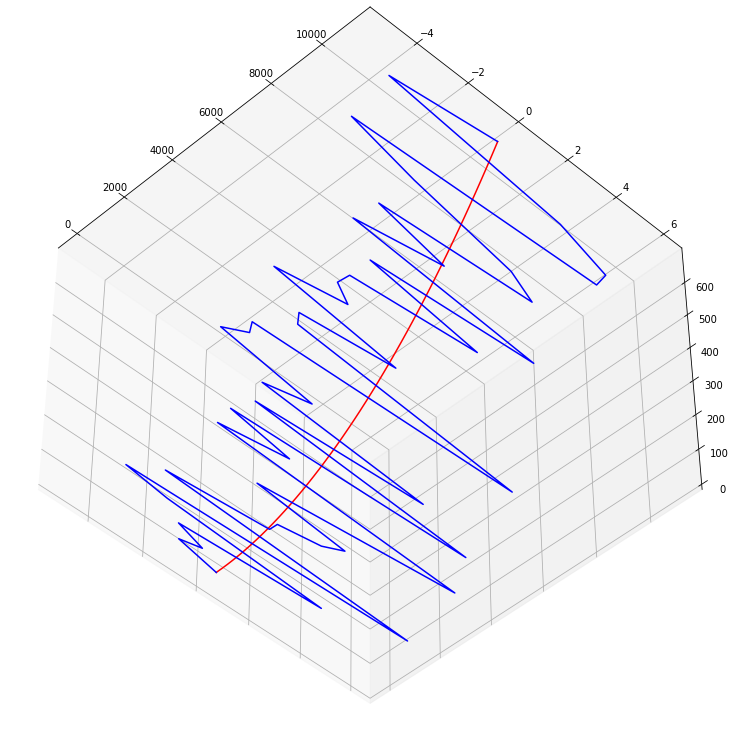

In [390]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [391]:
X,Y,Z

(array([    0.        ,   224.84242127,   451.08944188,   675.74436855,
          900.92784838,  1125.7975864 ,  1351.00029455,  1575.43651549,
         1802.36042841,  2028.7421312 ,  2252.91024163,  2480.63970537,
         2706.15727406,  2930.75536698,  3157.07492358,  3376.68495701,
         3607.40137416,  3833.20988118,  4058.47071494,  4280.80138319,
         4509.99740232,  4735.00490356,  4958.73209442,  5185.67101007,
         5409.01074667,  5635.09775958,  5861.24691155,  6081.6105022 ,
         6306.01172051,  6538.91757289,  6765.97659014,  6988.15967587,
         7217.25162149,  7442.15916296,  7666.41033821,  7892.36148038,
         8119.10432302,  8339.19326082,  8566.69362831,  8788.92411721,
         9020.40516042,  9243.03285385,  9465.44213123,  9697.57322712,
         9917.97514689, 10144.20475088, 10369.45224602, 10598.50662719,
        10821.40976507, 11051.95983844]),
 array([ 0.        , -1.62078158, -0.94345199, -2.04518993,  3.16357275,
        -2.87725715, 

In [392]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [393]:
us=fin.T

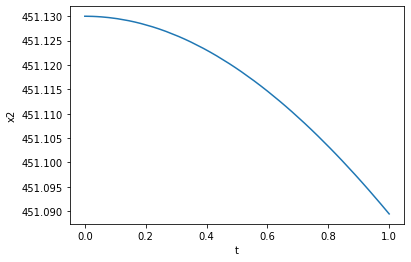

In [394]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

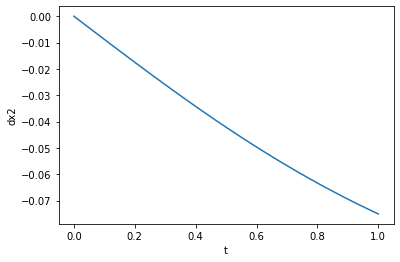

In [395]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

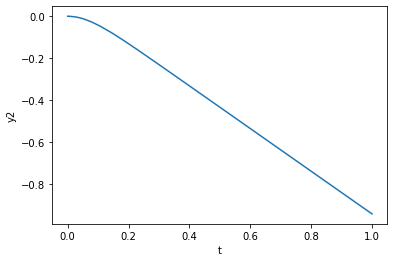

In [396]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

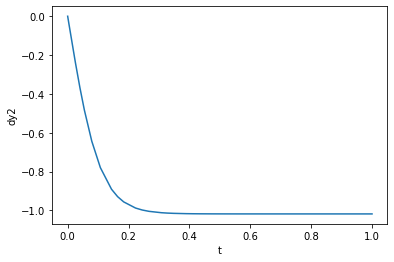

In [397]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

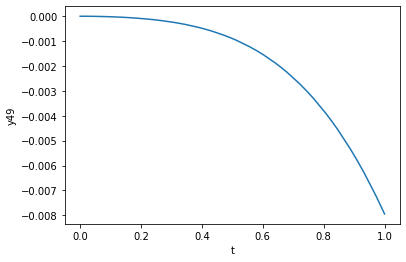

In [398]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

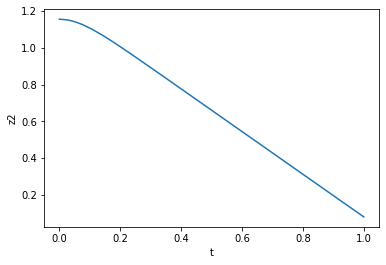

In [399]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

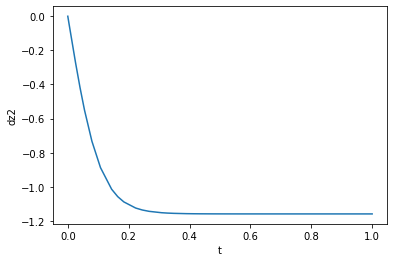

In [400]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

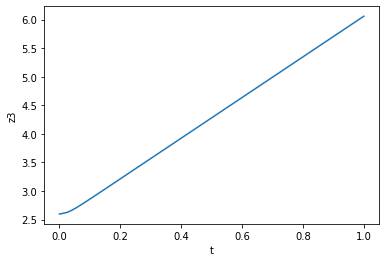

In [401]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

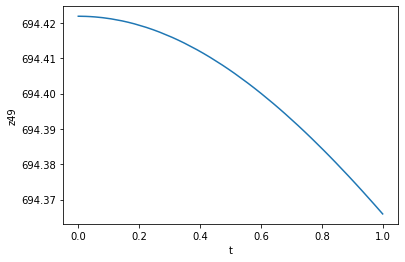

In [402]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

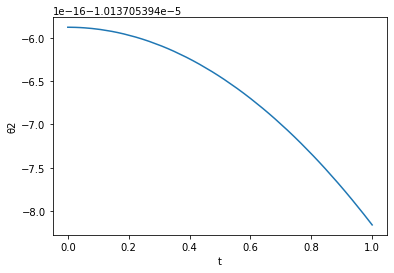

In [403]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

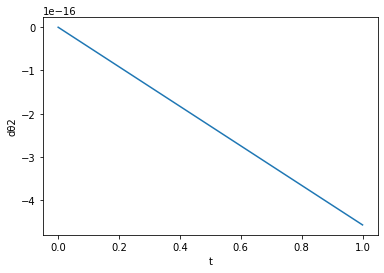

In [404]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

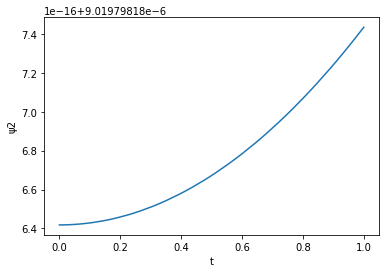

In [405]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

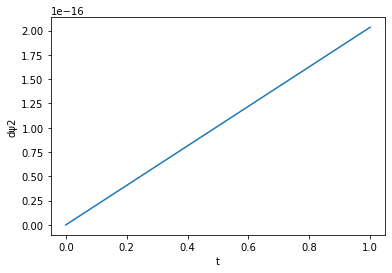

In [406]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()